# Experiment 01: Basic Neural Network Baseline
## Objective: Demonstrate why CNNs are better than fully connected networks for image data

This experiment uses a simple fully connected neural network to establish a baseline for the FER2013 dataset.

In [1]:
# Install necessary packages
!pip install wandb -q
!pip install kaggle -q

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import wandb
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Mount Google Drive (optional - for saving results)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:


# Setup kaggle directory
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download FER2013 dataset from Kaggle
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

# Extract the dataset
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip
!ls

 80% 227M/285M [00:00<00:00, 538MB/s] 
100% 285M/285M [00:06<00:00, 47.5MB/s]
challenges-in-representation-learning-facial-expression-recognition-challenge.zip
drive
example_submission.csv
fer2013.tar.gz
icml_face_data.csv
sample_data
test.csv
train.csv


In [7]:
# Initialize W&B
wandb.login()
run = wandb.init(
    project="fer-challenge",
    name="exp01-basic-nn",
    config={
        "architecture": "Basic NN",
        "dataset": "FER2013",
        "epochs": 30,
        "batch_size": 64,
        "learning_rate": 0.001,
        "hidden_size1": 512,
        "hidden_size2": 256,
        "hidden_size3": 128,
        "input_size": 48*48,
        "num_classes": 7
    }
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: qitiashvili13 (qitiashvili13-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [8]:
# Load and explore the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("\nTraining data columns:", train_df.columns.tolist())
print("\nEmotion distribution:")
print(train_df['emotion'].value_counts().sort_index())

Training data shape: (28709, 2)
Test data shape: (7178, 1)

Training data columns: ['emotion', 'pixels']

Emotion distribution:
emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: count, dtype: int64


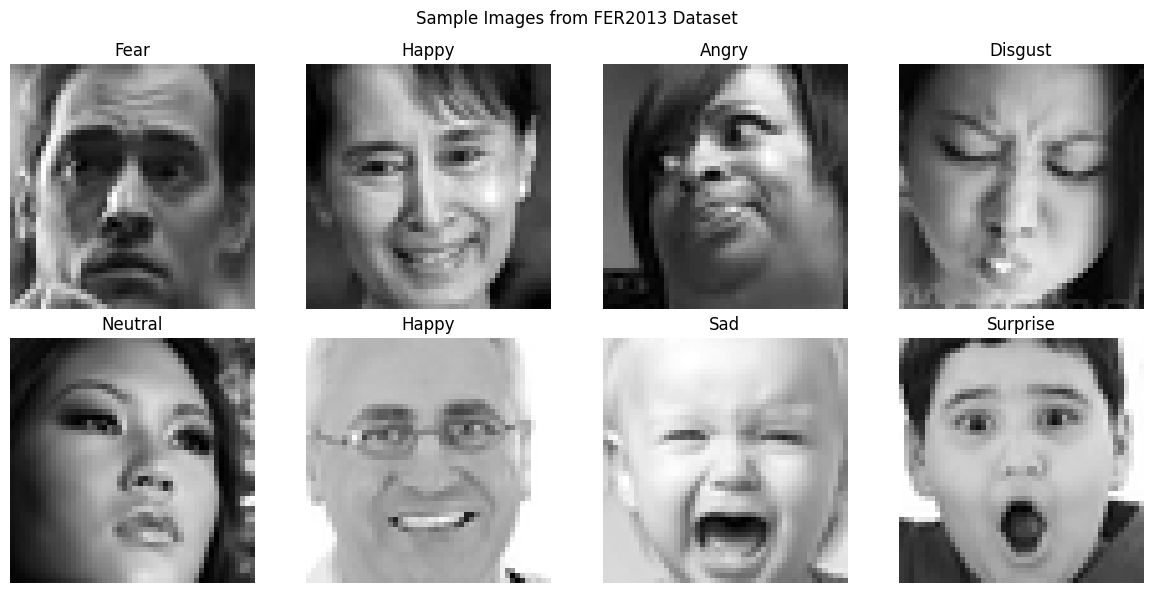

In [9]:
# Visualize sample images
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    idx = np.random.randint(0, len(train_df))
    pixels = train_df.iloc[idx]['pixels']
    emotion = train_df.iloc[idx]['emotion']

    # Convert pixel string to array and reshape
    pixels = np.array([int(pixel) for pixel in pixels.split(' ')], dtype=np.uint8)
    pixels = pixels.reshape(48, 48)

    axes[i].imshow(pixels, cmap='gray')
    axes[i].set_title(f'{emotion_labels[emotion]}')
    axes[i].axis('off')

plt.suptitle('Sample Images from FER2013 Dataset')
plt.tight_layout()
wandb.log({"sample_images": wandb.Image(plt)})
plt.show()

In [10]:
# Custom Dataset Class
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        emotion = self.data.iloc[idx]['emotion']

        # Convert pixel string to numpy array
        pixels = np.array([int(pixel) for pixel in pixels.split(' ')], dtype=np.float32)
        pixels = pixels / 255.0  # Normalize to [0, 1]

        # For basic NN, we keep it as a flat vector
        # For CNN experiments, we'll reshape to (1, 48, 48)

        return torch.tensor(pixels), torch.tensor(emotion, dtype=torch.long)

In [11]:
# Create datasets
full_dataset = FERDataset(train_df)

# Split into train and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

Train size: 22967
Validation size: 5742


In [12]:
# Basic Neural Network Model
class BasicNN(nn.Module):
    def __init__(self, input_size=48*48, hidden_size1=512, hidden_size2=256, hidden_size3=128, num_classes=7):
        super(BasicNN, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()

        self.fc4 = nn.Linear(hidden_size3, num_classes)

        # Calculate total parameters
        self.total_params = sum(p.numel() for p in self.parameters())

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)

        out = self.fc2(out)
        out = self.relu2(out)

        out = self.fc3(out)
        out = self.relu3(out)

        out = self.fc4(out)
        return out

In [13]:
# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = BasicNN().to(device)
print(f"Total parameters: {model.total_params:,}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Log model architecture to W&B
wandb.watch(model, log='all')

Using device: cpu
Total parameters: 1,345,287


In [14]:
# Print model architecture
print("Model Architecture:")
print("=" * 50)
for name, param in model.named_parameters():
    print(f"{name:20} {param.shape}")
print("=" * 50)

Model Architecture:
fc1.weight           torch.Size([512, 2304])
fc1.bias             torch.Size([512])
fc2.weight           torch.Size([256, 512])
fc2.bias             torch.Size([256])
fc3.weight           torch.Size([128, 256])
fc3.bias             torch.Size([128])
fc4.weight           torch.Size([7, 128])
fc4.bias             torch.Size([7])


In [15]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc='Training')
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': 100 * correct / total
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

In [16]:
# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(loader, desc='Validation')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix({
                'loss': loss.item(),
                'acc': 100 * correct / total
            })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc, all_predictions, all_labels

In [17]:
# Training loop
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0

for epoch in range(30):
    print(f'\nEpoch {epoch+1}/30')
    print('-' * 50)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    val_loss, val_acc, predictions, labels = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Log to W&B
    wandb.log({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'learning_rate': optimizer.param_groups[0]['lr']
    })

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_basic_nn_model.pth')
        print(f'New best model saved with validation accuracy: {val_acc:.2f}%')


Epoch 1/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 18.88it/s, loss=1.58, acc=32.4]


Train Loss: 1.7868, Train Acc: 26.60%
Val Loss: 1.7212, Val Acc: 32.45%
New best model saved with validation accuracy: 32.45%

Epoch 2/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 18.57it/s, loss=1.57, acc=33.5]


Train Loss: 1.7002, Train Acc: 32.42%
Val Loss: 1.6830, Val Acc: 33.52%
New best model saved with validation accuracy: 33.52%

Epoch 3/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:07<00:00, 11.68it/s, loss=1.48, acc=34.8]


Train Loss: 1.6676, Train Acc: 34.57%
Val Loss: 1.6623, Val Acc: 34.85%
New best model saved with validation accuracy: 34.85%

Epoch 4/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 17.52it/s, loss=1.47, acc=35.4]


Train Loss: 1.6501, Train Acc: 35.38%
Val Loss: 1.6567, Val Acc: 35.42%
New best model saved with validation accuracy: 35.42%

Epoch 5/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 18.85it/s, loss=1.51, acc=37.7]


Train Loss: 1.6346, Train Acc: 35.88%
Val Loss: 1.6310, Val Acc: 37.72%
New best model saved with validation accuracy: 37.72%

Epoch 6/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:06<00:00, 13.20it/s, loss=1.43, acc=38]


Train Loss: 1.6138, Train Acc: 36.91%
Val Loss: 1.6197, Val Acc: 37.97%
New best model saved with validation accuracy: 37.97%

Epoch 7/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 15.55it/s, loss=1.42, acc=38.2]


Train Loss: 1.6062, Train Acc: 36.89%
Val Loss: 1.6009, Val Acc: 38.17%
New best model saved with validation accuracy: 38.17%

Epoch 8/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 18.20it/s, loss=1.4, acc=39.4]


Train Loss: 1.5932, Train Acc: 37.71%
Val Loss: 1.5795, Val Acc: 39.38%
New best model saved with validation accuracy: 39.38%

Epoch 9/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 16.05it/s, loss=1.44, acc=38.6]


Train Loss: 1.5847, Train Acc: 37.71%
Val Loss: 1.5930, Val Acc: 38.61%

Epoch 10/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:06<00:00, 13.25it/s, loss=1.45, acc=38.2]


Train Loss: 1.5696, Train Acc: 38.62%
Val Loss: 1.6169, Val Acc: 38.19%

Epoch 11/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 18.74it/s, loss=1.44, acc=38.9]


Train Loss: 1.5752, Train Acc: 38.41%
Val Loss: 1.5880, Val Acc: 38.85%

Epoch 12/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:06<00:00, 13.14it/s, loss=1.42, acc=38.4]


Train Loss: 1.5538, Train Acc: 39.44%
Val Loss: 1.5729, Val Acc: 38.37%

Epoch 13/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:06<00:00, 14.09it/s, loss=1.37, acc=38.9]


Train Loss: 1.5384, Train Acc: 40.01%
Val Loss: 1.5699, Val Acc: 38.92%

Epoch 14/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 18.35it/s, loss=1.41, acc=37.5]


Train Loss: 1.5288, Train Acc: 40.43%
Val Loss: 1.5963, Val Acc: 37.50%

Epoch 15/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 15.55it/s, loss=1.42, acc=36.2]


Train Loss: 1.5248, Train Acc: 40.55%
Val Loss: 1.6116, Val Acc: 36.15%

Epoch 16/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:06<00:00, 13.22it/s, loss=1.32, acc=39.7]


Train Loss: 1.5093, Train Acc: 41.44%
Val Loss: 1.5614, Val Acc: 39.74%
New best model saved with validation accuracy: 39.74%

Epoch 17/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 18.82it/s, loss=1.4, acc=38.9]


Train Loss: 1.5036, Train Acc: 41.49%
Val Loss: 1.5607, Val Acc: 38.92%

Epoch 18/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, loss=1.42, acc=38.3]


Train Loss: 1.4934, Train Acc: 41.79%
Val Loss: 1.5908, Val Acc: 38.30%

Epoch 19/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:07<00:00, 12.00it/s, loss=1.33, acc=39.6]


Train Loss: 1.4813, Train Acc: 42.36%
Val Loss: 1.5593, Val Acc: 39.64%

Epoch 20/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 18.13it/s, loss=1.3, acc=38.6]


Train Loss: 1.4700, Train Acc: 42.79%
Val Loss: 1.5738, Val Acc: 38.58%

Epoch 21/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 17.77it/s, loss=1.41, acc=40.4]


Train Loss: 1.4610, Train Acc: 43.19%
Val Loss: 1.5471, Val Acc: 40.35%
New best model saved with validation accuracy: 40.35%

Epoch 22/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:07<00:00, 11.60it/s, loss=1.4, acc=38.7]


Train Loss: 1.4525, Train Acc: 43.65%
Val Loss: 1.5656, Val Acc: 38.68%

Epoch 23/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 18.53it/s, loss=1.39, acc=40]


Train Loss: 1.4438, Train Acc: 44.09%
Val Loss: 1.5573, Val Acc: 40.04%

Epoch 24/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 17.94it/s, loss=1.41, acc=40.1]


Train Loss: 1.4299, Train Acc: 44.95%
Val Loss: 1.5637, Val Acc: 40.11%

Epoch 25/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:06<00:00, 12.89it/s, loss=1.43, acc=39.3]


Train Loss: 1.4246, Train Acc: 44.79%
Val Loss: 1.5658, Val Acc: 39.32%

Epoch 26/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:06<00:00, 14.35it/s, loss=1.37, acc=40.5]


Train Loss: 1.4089, Train Acc: 45.75%
Val Loss: 1.5389, Val Acc: 40.49%
New best model saved with validation accuracy: 40.49%

Epoch 27/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 18.37it/s, loss=1.39, acc=38.2]


Train Loss: 1.4004, Train Acc: 45.96%
Val Loss: 1.5984, Val Acc: 38.16%

Epoch 28/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:06<00:00, 14.59it/s, loss=1.31, acc=40.9]


Train Loss: 1.3843, Train Acc: 46.65%
Val Loss: 1.5514, Val Acc: 40.86%
New best model saved with validation accuracy: 40.86%

Epoch 29/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 17.96it/s, loss=1.36, acc=40.4]


Train Loss: 1.3737, Train Acc: 46.71%
Val Loss: 1.5682, Val Acc: 40.44%

Epoch 30/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:06<00:00, 14.57it/s, loss=1.37, acc=39.1]

Train Loss: 1.3605, Train Acc: 47.63%
Val Loss: 1.5755, Val Acc: 39.08%


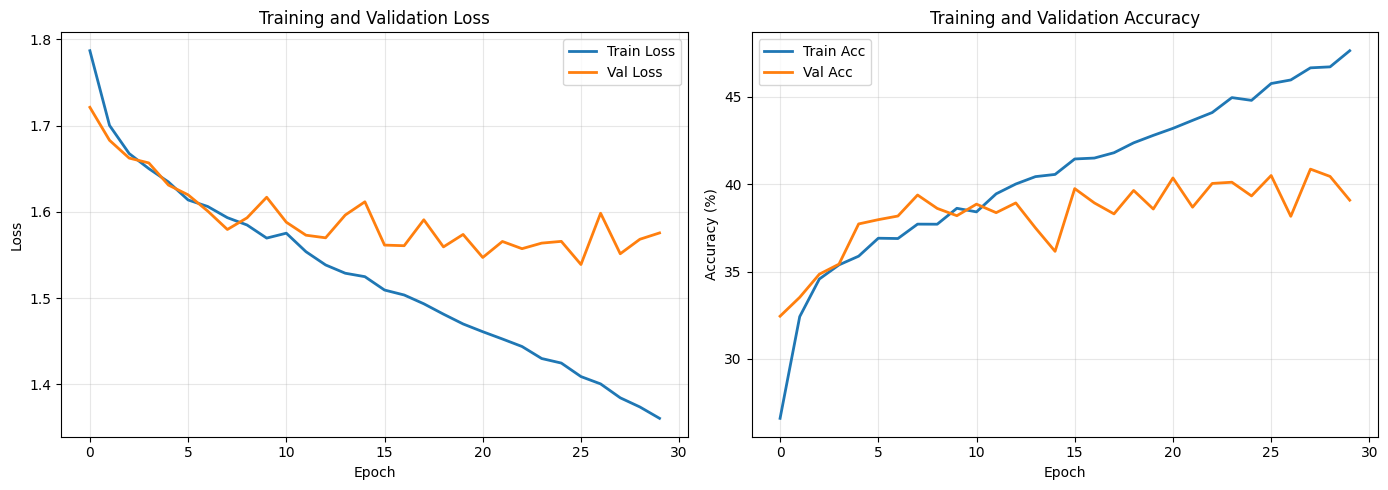

In [18]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accs, label='Train Acc', linewidth=2)
ax2.plot(val_accs, label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
wandb.log({"training_history": wandb.Image(plt)})
plt.show()

Validation: 100%|██████████| 90/90 [00:07<00:00, 12.39it/s, loss=1.31, acc=40.9]


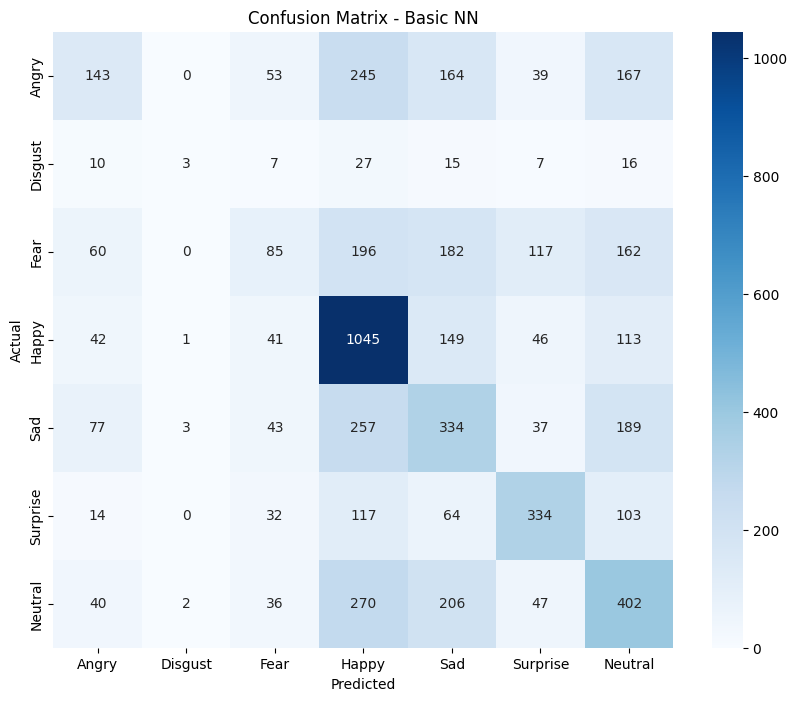

In [19]:
# Load best model for final evaluation
model.load_state_dict(torch.load('best_basic_nn_model.pth'))
_, _, final_predictions, final_labels = validate_epoch(model, val_loader, criterion, device)

# Confusion matrix
cm = confusion_matrix(final_labels, final_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Basic NN')
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

In [20]:
# Classification report
print("\nClassification Report:")
print("=" * 70)
report = classification_report(final_labels, final_predictions,
                             target_names=emotion_labels,
                             output_dict=True)
print(classification_report(final_labels, final_predictions, target_names=emotion_labels))

# Log per-class metrics to W&B
for emotion in emotion_labels:
    wandb.log({
        f"{emotion}_precision": report[emotion]['precision'],
        f"{emotion}_recall": report[emotion]['recall'],
        f"{emotion}_f1": report[emotion]['f1-score']
    })


Classification Report:
              precision    recall  f1-score   support

       Angry       0.37      0.18      0.24       811
     Disgust       0.33      0.04      0.06        85
        Fear       0.29      0.11      0.15       802
       Happy       0.48      0.73      0.58      1437
         Sad       0.30      0.36      0.33       940
    Surprise       0.53      0.50      0.52       664
     Neutral       0.35      0.40      0.37      1003

    accuracy                           0.41      5742
   macro avg       0.38      0.33      0.32      5742
weighted avg       0.39      0.41      0.38      5742



In [21]:
# Analyze misclassifications
misclassified_indices = np.where(np.array(final_predictions) != np.array(final_labels))[0]
correct_indices = np.where(np.array(final_predictions) == np.array(final_labels))[0]

print(f"\nTotal misclassifications: {len(misclassified_indices)} out of {len(final_labels)}")
print(f"Misclassification rate: {len(misclassified_indices)/len(final_labels)*100:.2f}%")


Total misclassifications: 3396 out of 5742
Misclassification rate: 59.14%


In [22]:
# Save final model and log to W&B
torch.save(model.state_dict(), 'final_basic_nn_model.pth')
wandb.save('final_basic_nn_model.pth')
wandb.save('best_basic_nn_model.pth')

# Summary statistics
summary_stats = {
    "final_train_accuracy": train_accs[-1],
    "final_val_accuracy": val_accs[-1],
    "best_val_accuracy": best_val_acc,
    "overfitting_gap": train_accs[-1] - val_accs[-1],
    "total_parameters": model.total_params,
    "macro_f1_score": report['macro avg']['f1-score'],
    "weighted_f1_score": report['weighted avg']['f1-score']
}

wandb.log(summary_stats)

In [23]:
# Final summary
print("\n" + "=" * 70)
print("EXPERIMENT SUMMARY: BASIC NEURAL NETWORK")
print("=" * 70)
print(f"\nModel Architecture:")
print(f"  - Input Layer: 2,304 neurons (48x48 pixels)")
print(f"  - Hidden Layer 1: 512 neurons")
print(f"  - Hidden Layer 2: 256 neurons")
print(f"  - Hidden Layer 3: 128 neurons")
print(f"  - Output Layer: 7 neurons (emotions)")
print(f"  - Total Parameters: {model.total_params:,}")

print(f"\nPerformance Metrics:")
print(f"  - Final Training Accuracy: {train_accs[-1]:.2f}%")
print(f"  - Final Validation Accuracy: {val_accs[-1]:.2f}%")
print(f"  - Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  - Overfitting Gap: {train_accs[-1] - val_accs[-1]:.2f}%")
print(f"  - Macro F1-Score: {report['macro avg']['f1-score']:.3f}")

print("\nKey Findings:")
print("  1. Basic NN treats the image as a flat vector, losing spatial structure")
print("  2. Performance is significantly limited compared to expected CNN performance")
print("  3. The model shows signs of overfitting despite relatively low accuracy")
print("  4. High parameter count (1.28M) for the achieved performance")
print("  5. Certain emotions (Happy, Surprise) are easier to classify than others")

print("\nConclusions:")
print("  - Spatial information is crucial for facial expression recognition")
print("  - Convolutional layers should significantly improve performance")
print("  - Need for better feature extraction mechanisms")
print("=" * 70)

# Close W&B run
wandb.finish()


EXPERIMENT SUMMARY: BASIC NEURAL NETWORK

Model Architecture:
  - Input Layer: 2,304 neurons (48x48 pixels)
  - Hidden Layer 1: 512 neurons
  - Hidden Layer 2: 256 neurons
  - Hidden Layer 3: 128 neurons
  - Output Layer: 7 neurons (emotions)
  - Total Parameters: 1,345,287

Performance Metrics:
  - Final Training Accuracy: 47.63%
  - Final Validation Accuracy: 39.08%
  - Best Validation Accuracy: 40.86%
  - Overfitting Gap: 8.55%
  - Macro F1-Score: 0.322

Key Findings:
  1. Basic NN treats the image as a flat vector, losing spatial structure
  2. Performance is significantly limited compared to expected CNN performance
  3. The model shows signs of overfitting despite relatively low accuracy
  4. High parameter count (1.28M) for the achieved performance
  5. Certain emotions (Happy, Surprise) are easier to classify than others

Conclusions:
  - Spatial information is crucial for facial expression recognition
  - Convolutional layers should significantly improve performance
  - Need 

Angry_f1,▁
Angry_precision,▁
Angry_recall,▁
Disgust_f1,▁
Disgust_precision,▁
Disgust_recall,▁
Fear_f1,▁
Fear_precision,▁
Fear_recall,▁
Happy_f1,▁
Happy_precision,▁
